In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

In [2]:
data_dir = 'archive/car_data/car_data'

mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
train_transforms = transforms.Compose([
            transforms.Resize((400, 400)),
            transforms.RandomCrop(350),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean, std, inplace=True)
        ])
train = ImageFolder(os.path.join(data_dir,'train'), train_transforms)

In [3]:
batch_size = 10
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=4, pin_memory=True)

In [4]:
def imshow(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    
    
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(14, 14))
        ax.set_xticks([]); ax.set_yticks([])
        imshow(make_grid(images[:10], nrow=5))
        break

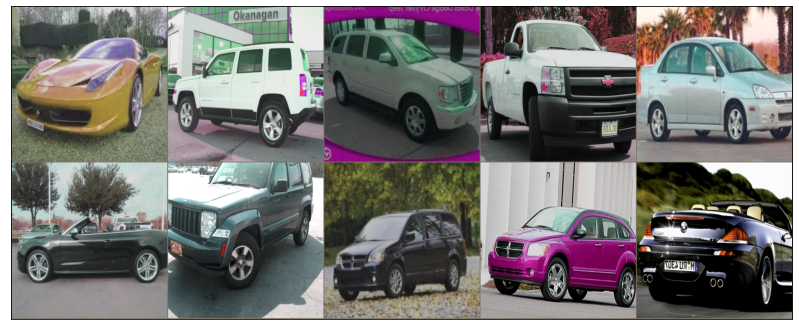

In [5]:
show_batch(train_dl)

In [6]:
import albumentations as albu
from albumentations.pytorch import ToTensorV2


def pre_transforms():
    return [albu.Resize(400, 400, p=1),
           albu.PadIfNeeded(min_height=400, min_width=400, always_apply=True, border_mode=0)]


def hard_transforms():
    result = [
        albu.RandomCrop(352, 352, always_apply=True),
        albu.HorizontalFlip(p=0.5),
        albu.OneOf([
            albu.RandomBrightnessContrast(
              brightness_limit=0.4, contrast_limit=0.4, p=1),
            albu.CLAHE(p=1),
            albu.HueSaturationValue(p=1)
        ],
            p=0.9,
        ),
        albu.OneOf([
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),
        albu.IAAAdditiveGaussianNoise(p=0.2)
    ]

    return result
  
def post_transforms():
    # we use ImageNet image normalization
    # and convert it to torch.Tensor
    return [albu.Normalize(), ToTensor()]
  
def compose(transforms_to_compose):
    # combine all augmentations into single pipeline
    result = albu.Compose([
      item for sublist in transforms_to_compose for item in sublist
    ])
    return result

In [7]:
from typing import List
import random
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread as gif_imread
from catalyst import utils
from pathlib import Path

ROOT = Path("archive/car_data/car_data/")
train_image_path = ROOT / "train/Audi S6 Sedan 2011/"
ALL_IMAGES = sorted(train_image_path.glob("*.jpg"))
len(ALL_IMAGES)


def show_examples(name: str, image: np.ndarray, image2: np.ndarray):
    plt.figure(figsize=(12, 16))
    plt.subplot(1, 2, 1)
    plt.imshow(image)

    plt.subplot(1, 2, 2)
    plt.imshow(image2)

def show(index: int, images: List[Path], transforms=None) -> None:
    image_path = images[index]
    image_path2 = images[index+4]
    name = image_path.name

    image = utils.imread(image_path)
    image2 = utils.imread(image_path2)
    temp = transforms(image=image)
    temp2 = transforms(image=image2)
    image = temp["image"]
    image2 = temp2['image']

    show_examples(name, image, image2)

def show_random(images: List[Path], transforms=None) -> None:
    length = len(images)
    index = random.randint(0, length - 5)
    show(index, images, transforms)
    
from torch.utils.data import Dataset


class ClassificationDataset(Dataset):
    def __init__(
        self,
        images: List[Path],
        transforms=None
    ) -> None:
        self.images = images
        self.transforms = transforms

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> dict:
        image_path = self.images[idx]
        image_path2 = self.images[idx+4]
        image = utils.imread(image_path)
        image2 = utils.imread(image_path2)
        
        result = {"image": image, 'image2':image2}
        result = self.transforms(**result)
        
        result["filename"] = image_path.name

        return result
    
show_transforms = compose([pre_transforms(), hard_transforms()])

C:\Users\aatmc\AppData\Local\Programs\Python\Python39\lib\site-packages\albumentations\imgaug\transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
C:\Users\aatmc\AppData\Local\Programs\Python\Python39\lib\site-packages\albumentations\imgaug\transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)


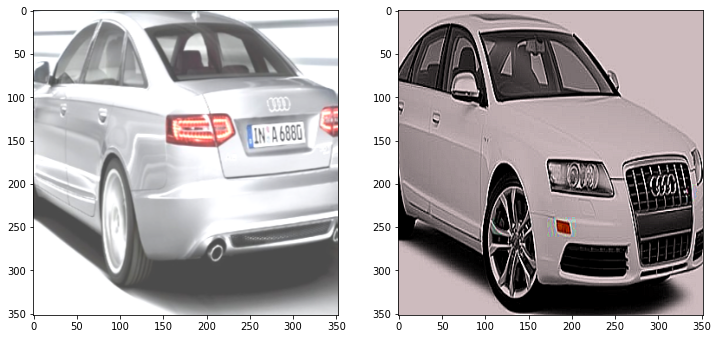

In [8]:
show_random(ALL_IMAGES, transforms=show_transforms)

In [9]:
import os
import numpy as np

import torch
import torch.nn as nn
from torch.nn import functional as F
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.metrics.functional.classification import accuracy
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateLogger
from pytorch_lightning.loggers import WandbLogger
from torch.optim import Adam
from torchvision import models, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from efficientnet_pytorch import EfficientNet

import wandb

from collections import OrderedDict
from typing import Optional
from torch.nn import Module

In [10]:
BN_TYPES = (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)


def _make_trainable(module: Module) -> None:
    """Unfreezes a given module.
    Args:
        module: The module to unfreeze
    """
    for param in module.parameters():
        param.requires_grad = True
    module.train()


def _recursive_freeze(module: Module,
                      train_bn: bool = True) -> None:
    """Freezes the layers of a given module.
    Args:
        module: The module to freeze
        train_bn: If True, leave the BatchNorm layers in training mode
    """
    children = list(module.children())
    if not children:
        if not (isinstance(module, BN_TYPES) and train_bn):
            for param in module.parameters():
                param.requires_grad = False
            module.eval()
        else:
            # Make the BN layers trainable
            _make_trainable(module)
    else:
        for child in children:
            _recursive_freeze(module=child, train_bn=train_bn)


def freeze(module: Module,
           n: Optional[int] = None,
           train_bn: bool = True) -> None:
    """Freezes the layers up to index n (if n is not None).
    Args:
        module: The module to freeze (at least partially)
        n: Max depth at which we stop freezing the layers. If None, all
            the layers of the given module will be frozen.
        train_bn: If True, leave the BatchNorm layers in training mode
    """
    children = list(module.children())
    n_max = len(children) if n is None else int(n)

    for child in children[:n_max]:
        _recursive_freeze(module=child, train_bn=train_bn)

    for child in children[n_max:]:
        _make_trainable(module=child)

In [11]:
class ResNet50(LightningModule):

    def __init__(self, 
                train_bn: bool = True,
                batch_size: int = 70,
                lr: float = 1e-3,
                num_workers: int = 4,
                hidden_1: int = 1024,
                hidden_2: int = 512,
                epoch_freeze: int = 8,
                total_steps: int = 15,
                pct_start: float = 0.2,
                anneal_strategy: str = 'cos',
                **kwargs):
        super().__init__()
        self.train_bn = train_bn
        self.batch_size = batch_size
        self.lr = lr
        self.num_workers = num_workers
        self.hidden_1 = hidden_1
        self.hidden_2 = hidden_2
        self.epoch_freeze = epoch_freeze
        self.total_steps = total_steps
        self.pct_start = pct_start
        self.anneal_strategy = anneal_strategy
        self.save_hyperparameters()

        self.__build_model()
        
    def __build_model(self):
        num_target_classes = 196
        backbone = models.resnet50(pretrained=True)
    
        _layers = list(backbone.children())[:-1]
        self.feature_extractor = nn.Sequential(*_layers)

        _fc_layers = [nn.Linear(2048, self.hidden_1),
                     nn.Linear(self.hidden_1, self.hidden_2),
                     nn.Linear(self.hidden_2, num_target_classes)]
        self.fc = nn.Sequential(*_fc_layers)

    def forward(self, x):

        x = self.feature_extractor(x)
        x = x.squeeze(-1).squeeze(-1)

        x = self.fc(x)
        return x
    
    def train(self, mode=True):
        super().train(mode=mode)

        epoch = self.current_epoch
        if epoch < self.epoch_freeze and mode:
            freeze(module=self.feature_extractor,
                   train_bn=self.train_bn) 
            
    def training_step(self, batch, batch_idx):

        x, y = batch
        y_logits = self.forward(x)

        train_loss = F.cross_entropy(y_logits, y)
        acc = accuracy(y_logits, y)

        tqdm_dict = {'train_loss': train_loss}
        output = OrderedDict({'loss': train_loss,
                               'train_acc': acc,
                              'log': tqdm_dict,
                             'progress_bar': tqdm_dict})

        return output


    def training_epoch_end(self, outputs):

        train_loss_mean = torch.stack([output['loss']
                                       for output in outputs]).mean()
        avg_acc = torch.stack([x['train_acc'] for x in outputs]).mean()
        
        tensorboard_logs = {'train_loss': train_loss_mean, 'train_acc': avg_acc}
        return {'train_loss': train_loss_mean,  'log': tensorboard_logs}


    def validation_step(self, batch, batch_idx):

        x, y = batch
        y_logits = self.forward(x)

        val_loss = F.cross_entropy(y_logits, y)
        acc = accuracy(y_logits, y)

        return {'val_loss': val_loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        
        val_loss_mean = torch.stack([output['val_loss']
                                     for output in outputs]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in outputs]).mean()
        
        tensorboard_logs = {'val_loss': val_loss_mean, 'val_acc': avg_acc}
        return {'val_loss': val_loss_mean,  'log': tensorboard_logs}
        

    def configure_optimizers(self):
        if self.current_epoch < self.epoch_freeze:
        
            optimizer = optim.Adam(filter(lambda p: p.requires_grad,
                                      self.parameters()),
                                   lr=self.lr)
            return optimizer
        
        else:
            
            optimizer = optim.Adam(filter(lambda p: p.requires_grad,
                                      self.parameters()),
                                   lr=self.lr)
            
            scheduler = OneCycleLR(optimizer,
                            max_lr=self.lr,
                            total_steps=self.total_steps,
                            pct_start=self.pct_start, anneal_strategy=self.anneal_strategy)

        return [optimizer], [scheduler]

    def setup(self, stage: str):
        data_dir = '../input/stanford-car-dataset-by-classes-folder/car_data/car_data'

        mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
        train_transforms = transforms.Compose([
            transforms.Resize((400, 400)),
            transforms.RandomCrop(350),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean, std, inplace=True)
        ])
        train = ImageFolder(data_dir+'/train', train_transforms)

        # transform val
        val_transforms = transforms.Compose([
            transforms.Resize((400, 400)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std, inplace=True)
        ])
        val = ImageFolder(data_dir+'/test', val_transforms)
        valid, _ = random_split(val, [len(val), 0])

        # assign to use in dataloaders
        self.train_dataset = train
        self.val_dataset = valid

    def train_dataloader(self):
        return DataLoader(dataset=self.train_dataset,
                            batch_size=self.batch_size,
                            num_workers=self.num_workers,
                            shuffle=True,
                            pin_memory=True)

    def val_dataloader(self):
        return DataLoader(dataset=self.val_dataset,
                            batch_size=self.batch_size,
                            num_workers=self.num_workers,
                            shuffle=False,
                            pin_memory=True)

In [17]:
def main():

    seed_everything(42)
    model = ResNet50()

    wandb.login(key=os.environ.get('WANDB_API_KEY'))
    
    wandb_logger = WandbLogger(name='Name', project="Project")
    
    checkpoint_cb = ModelCheckpoint(filepath = './cars-{epoch:02d}-{val_acc:.4f}',monitor='val_acc', mode='max')
    early = EarlyStopping(patience=5, monitor='val_acc', mode='max')

    trainer = Trainer(
        gpus = 1,
        logger=wandb_logger,
        max_epochs=15,
        deterministic=True,
        precision=16,
        checkpoint_callback=checkpoint_cb,
        early_stop_callback=early,
        callbacks=[LearningRateLogger()],
    )

    trainer.fit(model)
    
    wandb.save(checkpoint_cb.best_model_path)

if __name__ == '__main__':
    main()

MisconfigurationException: 
                You requested GPUs: [0]
                But your machine only has: []
            